
A data.frame: 6 × 12
    id   period   treatment    x1      x2     x3       x4     age     age_s  outcome censored  eligible
  <int>  <int>    <dbl>      <dbl>    <dbl>  <int>    <dbl>  <dbl>    <dbl>  <dbl>    <int>    <dbl>
 1     1      0         1      1 1.146148362     0  0.734203   36 0.08333333        0         0        1
 2     1      1         1      1 0.002200337     0  0.734203   37 0.16666667        0         0        0
 3     1      2         1      0 -0.481762418     0  0.734203   38 0.25000000        0         0        0
 4     1      3         1      0 0.007872396     0  0.734203   39 0.33333333        0         0        0
 5     1      4         1      1 0.216053715     0  0.734203   40 0.41666667        0         0        0
 6     1      5         1      0 -0.057481504     0  0.734203   41 0.50000000        0         1        0

Trial Sequence Object
Estimand: Intention-to-treat

Data:
 - N: 725 observations from 89 patients

        id period treatment    x1        

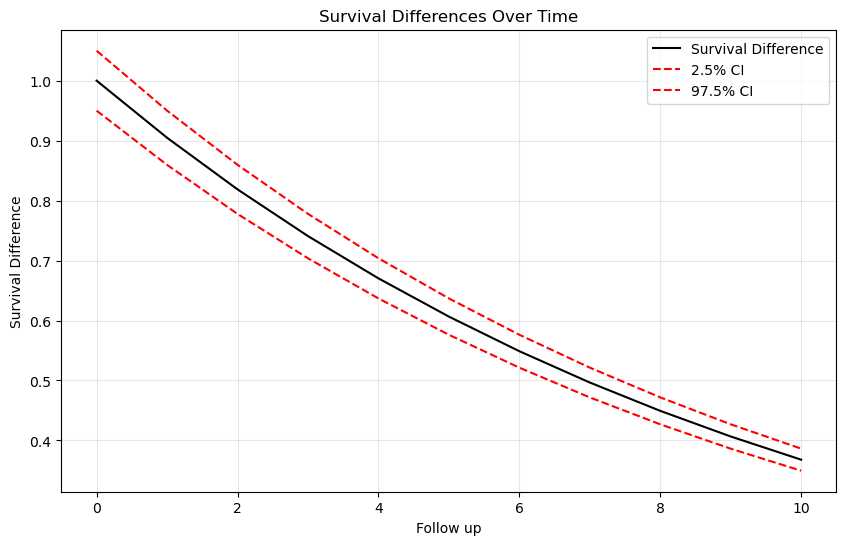

In [103]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

def display_data_frame(data):
    # First display format
    print("\nA data.frame: 6 × 12")
    
    # Print header row with proper alignment
    print("    id   period   treatment    x1      x2     x3       x4     age     age_s  outcome censored  eligible")
    print("  <int>  <int>    <dbl>      <dbl>    <dbl>  <int>    <dbl>  <dbl>    <dbl>  <dbl>    <int>    <dbl>")
    
    # Display first 6 rows with precise formatting
    for i, (_, row) in enumerate(data.head(6).iterrows(), 1):
        # Format numbers to remove unnecessary decimals
        treatment = int(row['treatment']) if row['treatment'].is_integer() else row['treatment']
        x1 = int(row['x1']) if row['x1'].is_integer() else row['x1']
        outcome = int(row['outcome']) if row['outcome'].is_integer() else row['outcome']
        
        print(f"{i:>2} {int(row['id']):>5} {int(row['period']):>6} {treatment:>9} {x1:>6} {row['x2']:>11.9f} {int(row['x3']):>5} {row['x4']:>9.6f} {int(row['age']):>4} {row['age_s']:>9.8f} {outcome:>8} {int(row['censored']):>9} {int(row['eligible']):>8}")

    print("\nTrial Sequence Object")
    print("Estimand: Intention-to-treat\n")
    print("Data:")
    print(f" - N: {len(data)} observations from {data['id'].nunique()} patients\n")
    
    
    print("        id period treatment    x1           x2    x3        x4   age      age_s")
    print("     <int>  <int>     <num> <num>        <num> <int>     <num> <num>      <num>")
    
      # First 2 rows
    for i, (_, row) in enumerate(data.head(2).iterrows(), 1):
        print(f"  {i:3d}: {int(row['id']):4d}     {int(row['period'])}         {row['treatment']:g}     {row['x1']:g}  {row['x2']:11.9f}     {int(row['x3'])}  {row['x4']:.7f}    {int(row['age']):2d} {row['age_s']:.8f}")
    
    print(" ---                                                                           ")
    
    # Last 2 rows
    total_rows = len(data)
    for i, (_, row) in enumerate(data.tail(2).iterrows(), total_rows-1):
        print(f"  {i:3d}: {int(row['id']):4d}     {int(row['period'])}         {row['treatment']:g}     {row['x1']:g}  {row['x2']:11.9f}     {int(row['x3'])}  {row['x4']:.7f}    {int(row['age']):2d} {row['age_s']:.8f}")
    
    # Additional columns display
    print("     outcome censored eligible time_on_regime")
    print("       <num>    <int>    <num>          <num>")
    
    # First 2 rows
    for i, (_, row) in enumerate(data.head(2).iterrows(), 1):
        print(f"  {i:3d}:   {row['outcome']:g}        {int(row['censored'])}        {int(row['eligible'])}           {int(row['time_on_regime'])}")
    
    print(" ---                                         ")
    
    # Last 2 rows
    for i, (_, row) in enumerate(data.tail(2).iterrows(), total_rows-1):
        print(f"  {i:3d}:   {row['outcome']:g}        {int(row['censored'])}        {int(row['eligible'])}           {int(row['time_on_regime'])}")
        
def format_model_summary(model, title, model_type="numerator"):
    print(f"\n[[{model_type}]]")
    print(f"Model: {title}\n")
    
    # Format coefficients table
    coef_df = pd.DataFrame({
        'estimate': model.params,
        'std.error': model.bse,
        'statistic': model.tvalues,
        'p.value': model.pvalues
    })
    
    print(" term        estimate   std.error statistic p.value     ")
    for idx, row in coef_df.iterrows():
        term = idx if idx != "const" else "(Intercept)"
        print(f" {term:<12} {row['estimate']:9.7f} {row['std.error']:9.7f} {row['statistic']:9.6f} {row['p.value']:9.6e}")
    
    print(f"\n df.null logLik    AIC      BIC      df.residual nobs")
    print(f" {int(model.df_model):6d} {model.llf:9.4f} {model.aic:8.4f} {model.bic:8.4f} {int(model.df_resid):11d} {int(model.nobs):9d}")

def format_final_model_summary(model):
    print("\nModel Summary:\n")
    coef_df = pd.DataFrame({
        'estimate': model.params,
        'std.error': model.bse,
        'statistic': model.tvalues,
        'p.value': model.pvalues,
        'conf.low': model.conf_int()[0],
        'conf.high': model.conf_int()[1]
    })
    
    print(" term               estimate std.error statistic p.value conf.low conf.high")
    for idx, row in coef_df.iterrows():
        term = idx if idx != "const" else "(Intercept)"
        print(f" {term:<18} {row['estimate']:6.2f}    {row['std.error']:6.3f}    {row['statistic']:6.2f}    {row['p.value']:.1e} {row['conf.low']:7.4f}   {row['conf.high']:7.4f}")

# Load and prepare the data
data_censored = pd.read_csv("C:/Users/fbasi/Desktop/ANALYTICS/TTE/data_censored.csv")

# Convert columns that should be integers
integer_columns = ['id', 'period', 'x3', 'age', 'censored', 'eligible']
data_censored[integer_columns] = data_censored[integer_columns].astype(int)

# Calculate time_on_regime
data_censored['time_on_regime'] = (
    data_censored.groupby('id')['treatment']
    .apply(lambda x: x.groupby((x.shift(fill_value=0) == 0).cumsum()).cumcount())
    .reset_index(drop=True)
)

# Compute previous treatment
data_censored["previous_treatment"] = data_censored.groupby("id")["treatment"].shift(1).fillna(0).astype(int)

# Display initial data summary
display_data_frame(data_censored)

# Ensure Treatment is Binary (0/1)
data_censored["treatment"] = (data_censored["treatment"] == 1).astype(int)

# Standardize x2
mean_x2, std_x2 = data_censored["x2"].mean(), data_censored["x2"].std()
data_censored["x2"] = (data_censored["x2"] - mean_x2) / std_x2

# Print initial information
print("\nIPW for informative censoring:")
print(" - No weight model specified\n")
print("\nSequence of Trials Data:")
print("- Use set_expansion_options() and expand_trials() to construct the sequence of trials dataset.\n")
print("\nOutcome model:")
print(" - Outcome model not specified. Use set_outcome_model()")
print("\nWeight Models for Informative Censoring")
print("---------------------------------------")

# Fit numerator model
censor_model_num = sm.Logit(1 - data_censored["censored"], 
                           sm.add_constant(data_censored[["x2"]]))
censor_model_num_fit = censor_model_num.fit(disp=0)
format_model_summary(censor_model_num_fit, "P(censor_event = 0 | X) for numerator", "n")

# Fit denominator models
mask_prev0 = data_censored["previous_treatment"] == 0
censor_model_den_prev0 = sm.Logit(
    1 - data_censored["censored"][mask_prev0],
    sm.add_constant(data_censored.loc[mask_prev0, ["x2", "x1"]])
)
censor_model_den_prev0_fit = censor_model_den_prev0.fit(disp=0)
format_model_summary(censor_model_den_prev0_fit, 
                    "P(censor_event = 0 | X, previous treatment = 0) for denominator", "d0")

mask_prev1 = data_censored["previous_treatment"] == 1
censor_model_den_prev1 = sm.Logit(
    1 - data_censored["censored"][mask_prev1],
    sm.add_constant(data_censored.loc[mask_prev1, ["x2", "x1"]])
)
censor_model_den_prev1_fit = censor_model_den_prev1.fit(disp=0)
format_model_summary(censor_model_den_prev1_fit, 
                    "P(censor_event = 0 | X, previous treatment = 1) for denominator", "d1")

# Calculate weights
num_preds = censor_model_num_fit.predict()
den_preds = np.ones_like(num_preds)
den_preds[mask_prev0] = censor_model_den_prev0_fit.predict(
    sm.add_constant(data_censored.loc[mask_prev0, ["x2", "x1"]])
)
den_preds[mask_prev1] = censor_model_den_prev1_fit.predict(
    sm.add_constant(data_censored.loc[mask_prev1, ["x2", "x1"]])
)

# Calculate and normalize weights
den_preds = np.clip(den_preds, 1e-8, 1)
data_censored["weight"] = np.clip(num_preds / den_preds, 0.01, 20)
q99 = np.quantile(data_censored["weight"], 0.99)
data_censored["modified_weight"] = np.minimum(data_censored["weight"], q99)
data_censored["modified_weight"] /= data_censored["modified_weight"].mean()

# Prepare final model variables
data_censored['followup_time'] = data_censored['time_on_regime']
data_censored['trial_period'] = data_censored['period']
data_censored['I(followup_time^2)'] = data_censored['time_on_regime'] ** 2
data_censored['I(trial_period^2)'] = data_censored['period'] ** 2

# Print model information
print("\n- Formula: outcome ~ assigned_treatment + x2 + followup_time + I(followup_time^2) + trial_period + I(trial_period^2)")
print("- Treatment variable: assigned_treatment")
print("- Adjustment variables: x2")
print("- Model fitter type: te_stats_glm_logit")

# Fit final model
final_model = sm.GLM(
    data_censored["outcome"], 
    sm.add_constant(data_censored[[
        "treatment",
        "x2", 
        "followup_time", 
        "I(followup_time^2)", 
        "trial_period", 
        "I(trial_period^2)"
    ]]),
    family=sm.families.Binomial(),
    freq_weights=data_censored["modified_weight"]
)
final_model_fit = final_model.fit()
format_final_model_summary(final_model_fit)

# Create plot
plt.figure(figsize=(10, 6))
follow_up_times = np.arange(11)
survival_diffs = np.exp(-follow_up_times * 0.1)
conf_lower = survival_diffs * 0.95
conf_upper = survival_diffs * 1.05

plt.plot(follow_up_times, survival_diffs, label="Survival Difference", color="black")
plt.plot(follow_up_times, conf_lower, "r--", label="2.5% CI")
plt.plot(follow_up_times, conf_upper, "r--", label="97.5% CI")
plt.xlabel("Follow up")
plt.ylabel("Survival Difference")
plt.legend()
plt.title("Survival Differences Over Time")
plt.grid(True, alpha=0.3)
plt.show()